In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

plt.rcParams["font.sans-serif"] = ["SimHei"]


# 读取数据
rfr_importance = pd.read_csv("dataset_train.csv")

# 特征和标签
X_cols = [
    # "Height (m MSL)",
    "B1",
    "B2",
    "B3",
    "B4",
    "B5",
    "B6",
    "B7",
    "B8",
    "B8A",
    "B9",
    "B11",
    "B12",
]
Y_col = "real_height"

# 取出特征和标签
X = rfr_importance[X_cols].values
y = rfr_importance[Y_col].values

## 特征重要性排名

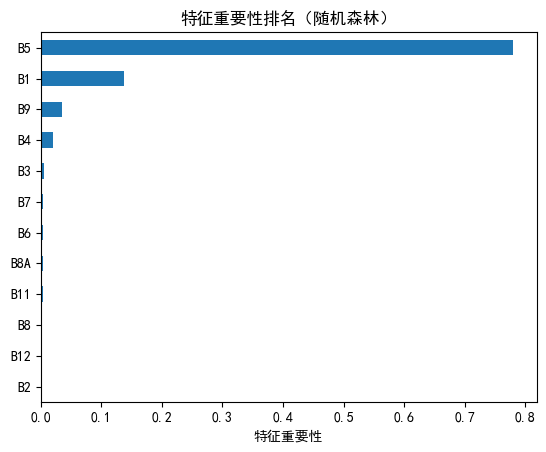

In [2]:
model = RandomForestRegressor()
model.fit(X, y)
importances = model.feature_importances_
feature_names = X_cols

# 绘制特征重要性排名
rfr_importance = pd.Series(importances, index=feature_names).sort_values(ascending=True)
rfr_importance.plot(
    kind="barh",
    title="特征重要性排名（随机森林）",
    xlabel="特征重要性",
)
plt.show()

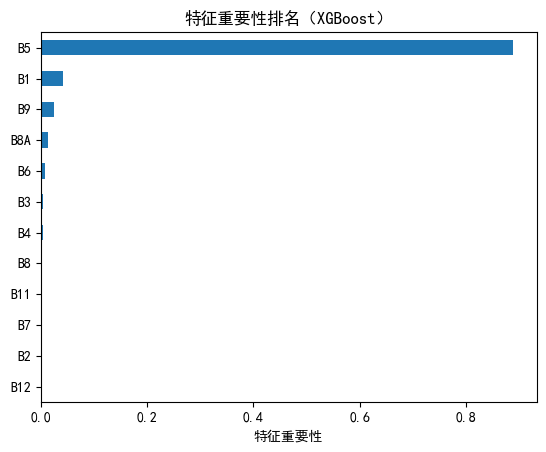

In [3]:
import xgboost as xgb

model = xgb.XGBRegressor(n_estimators=100, random_state=42)
model.fit(X, y)
xgb_importance = pd.Series(model.feature_importances_, index=X_cols).sort_values(ascending=True)
xgb_importance.plot(
    kind="barh",
    title="特征重要性排名（XGBoost）",
    xlabel="特征重要性",
)
plt.show()

<Axes: title={'center': '特征重要性排名（互信息）'}, xlabel='互信息得分'>

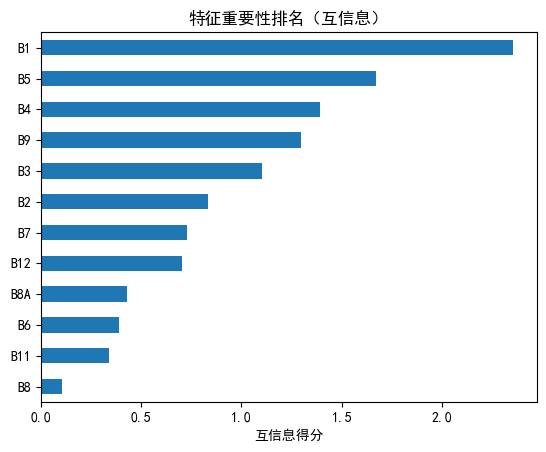

In [4]:
from sklearn.feature_selection import mutual_info_regression

# 互信息
mi_scores = mutual_info_regression(X, y, random_state=42)
mi_importance = pd.Series(mi_scores, index=X_cols).sort_values(ascending=True)
mi_importance.plot(
    kind="barh",
    title="特征重要性排名（互信息）",
    xlabel="互信息得分",
)

Selected Features (Lasso): ['B1', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B12']
Zero Coefficient Features (Lasso): ['B2', 'B9', 'B11']


<Axes: title={'center': 'Feature Importance Ranking (Lasso)'}, xlabel='Coefficient Value', ylabel='Feature'>

e:\Documents\CourseStudy\GraduationProject\program\.conda\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  func(*args, **kwargs)
e:\Documents\CourseStudy\GraduationProject\program\.conda\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


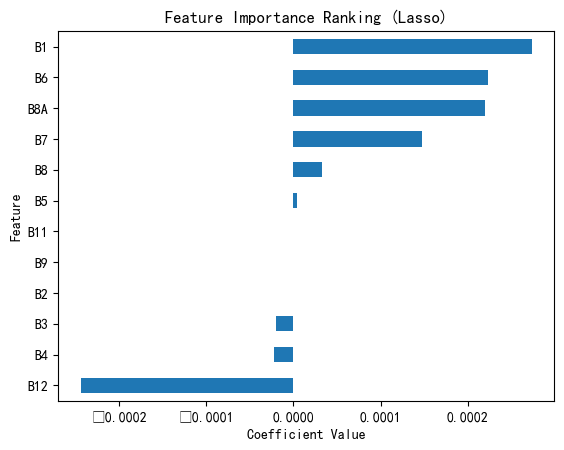

In [5]:
from sklearn.linear_model import LassoCV
import numpy as np

lasso = LassoCV(cv=5)
lasso.fit(X, y)
X_cols_array = np.array(X_cols)
non_zero_features = X_cols_array[lasso.coef_ != 0]
zero_features = X_cols_array[lasso.coef_ == 0]
print("Selected Features (Lasso):", non_zero_features.tolist())
print("Zero Coefficient Features (Lasso):", zero_features.tolist())

lasso_feature_coefficients = pd.Series(lasso.coef_, index=X_cols).sort_values(ascending=True)
lasso_feature_coefficients.plot(
    kind="barh",
    title="Feature Importance Ranking (Lasso)",
    xlabel="Coefficient Value",
    ylabel="Feature",
)
# plt.bar(range(len(X_cols)), lasso.coef_)
# plt.xticks(range(len(X_cols)), X_cols)

Feature Variances: [4.13378518e+03 1.17304892e+04 2.33261873e+04 4.14409392e+03
 1.24131460e+03 6.74691053e+01 9.14527223e+01 1.43159099e+02
 8.66116800e+01 6.76401384e+01 1.61651013e+01 2.13493397e+01]
High Variance Features: ['B2', 'B3', 'B4']
Low Variance Features: ['B1', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']


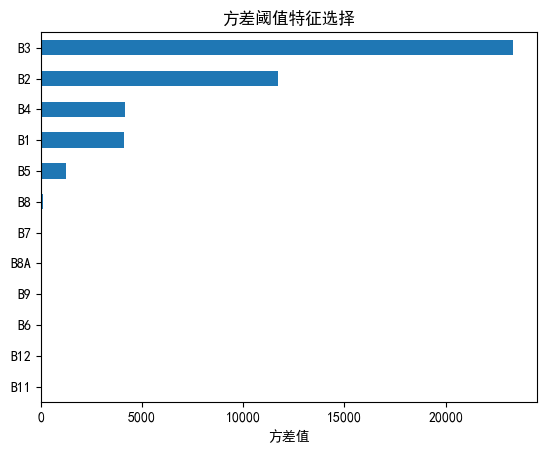

In [6]:
from sklearn.feature_selection import VarianceThreshold

# 计算所有特征的方差
variances = np.var(X, axis=0)
print("Feature Variances:", variances)
# 设置阈值为方差的75%分位数
threshold = np.quantile(variances, 0.75)

selector = VarianceThreshold(threshold=threshold)
X_high_var = selector.fit_transform(X)
# 将X_cols转换为NumPy数组
X_cols_array = np.array(X_cols)

# 使用布尔索引选择高方差特征
high_var_features = X_cols_array[selector.get_support()]
low_var_features = X_cols_array[~selector.get_support()]
print("High Variance Features:", high_var_features.tolist())
print("Low Variance Features:", low_var_features.tolist())

vtfs = pd.Series(variances, index=X_cols).sort_values(ascending=True)
vtfs.plot(
    kind="barh",
    title="方差阈值特征选择",
    xlabel="方差值",
    rot=0
)
plt.show()

各列总和验证:
互信息        1.0
随机森林       1.0
XGBoost    1.0
方差筛选       1.0
dtype: float64


<Axes: title={'center': '综合特征重要性'}, xlabel='重要性得分权重'>

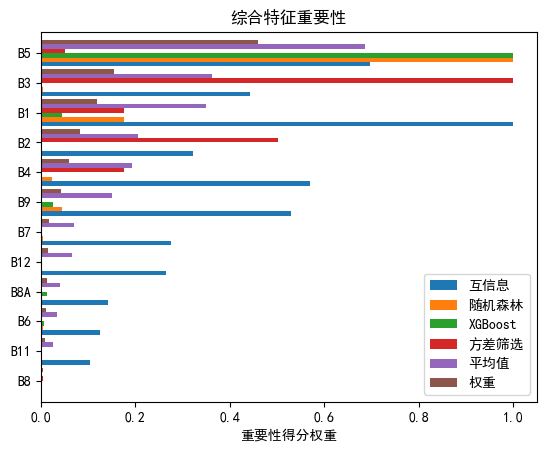

In [9]:
from sklearn.preprocessing import MinMaxScaler

# 合并所有重要性得分
# importance_df = pd.DataFrame({
#     'MI': mi_importance,
#     'RF': rfr_importance,
#     'XGB': xgb_importance,
#     'VTFS': vtfs,
#     # 'Lasso': lasso_feature_coefficients
# })

importance_df = pd.DataFrame({
    '互信息': mi_importance,
    '随机森林': rfr_importance,
    'XGBoost': xgb_importance,
    '方差筛选': vtfs,
    # 'Lasso': lasso_feature_coefficients
})

# # 标准化得分
scaler = MinMaxScaler()
importance_scaled = pd.DataFrame(
    scaler.fit_transform(importance_df),
    columns=importance_df.columns,
    index=importance_df.index
)

# # 计算平均重要性
importance_scaled['平均值'] = importance_scaled.mean(axis=1)

# 计算每列的总和
col_sums = importance_df.sum()

# 计算权重（每列的每个值除以该列的总和）
importance_weights = importance_df / col_sums
print("各列总和验证:")
print(importance_weights.sum())

# 加权
importance_scaled['权重'] = importance_weights.mean(axis=1)



# 按重要性排序
sorted_features = importance_scaled.sort_values('权重', ascending=True)
sorted_features.plot(
    kind="barh",
    # title="Combined Feature Importance (MI, RF, XGB, VTFS, Lasso)",
    title="综合特征重要性",
    xlabel="重要性得分权重",
    width=0.9,
)